In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.4 MB/s eta 0:00:00


In [4]:
import os
import zipfile
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import shap

In [5]:
def extract_features(file_path, zip_file):
    with zip_file.open(file_path) as file:
        y, sr = librosa.load(file, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_DB = librosa.power_to_db(S, ref=np.max)
        return S_DB, sr, y

zip_path = '/content/drive/MyDrive/Bird sound classification data/archive (1).zip'
metadata_path = '/content/drive/MyDrive/Bird sound classification data/bird_songs_metadata.csv'
metadata = pd.read_csv(metadata_path)

In [6]:
species_of_interest = ['bewickii', 'polyglottos', 'migratorius', 'melodia', 'cardinalis']
metadata = metadata[metadata['species'].isin(species_of_interest)]

feature_list = []
labels = []

with zipfile.ZipFile(zip_path, 'r') as z:
    for index, row in metadata.iterrows():
        file_path = os.path.join('wavfiles', row['filename'])
        if file_path in z.namelist():
            S_DB, sr, y = extract_features(file_path, z)
            feature_list.append(np.mean(S_DB, axis=1))  # Mean over time
            labels.append(row['species'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(feature_list, labels, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_scaled, y_train_encoded)

RandomForestClassifier()

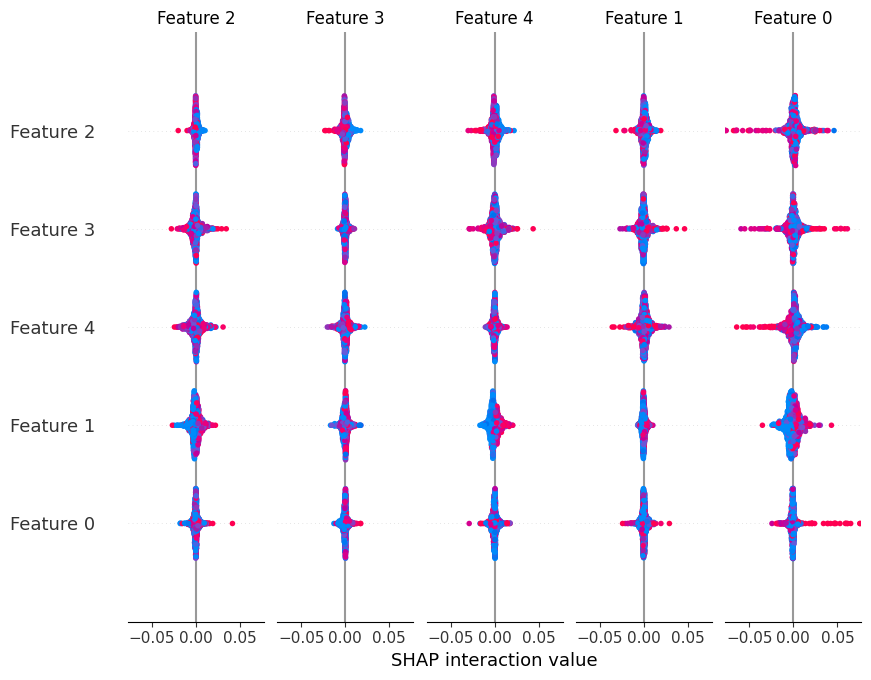

In [8]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, plot_type="bar")

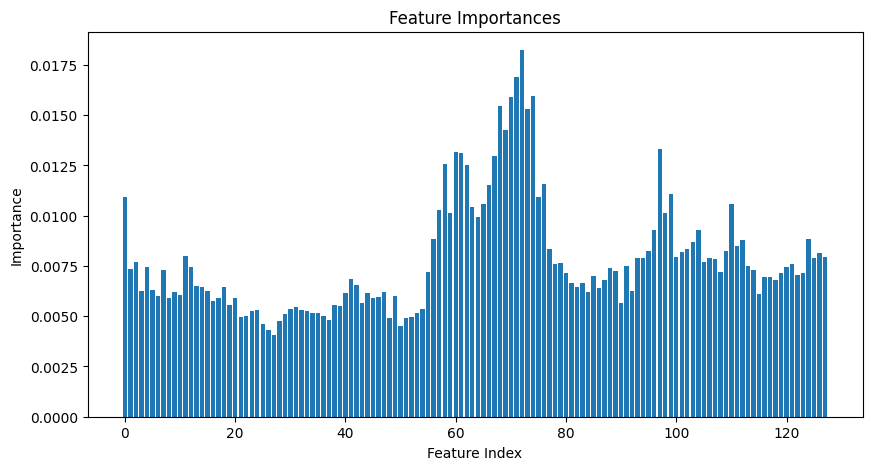

In [9]:
importances = rf.feature_importances_
plt.figure(figsize=(10, 5))
plt.title('Feature Importances')
plt.bar(range(len(importances)), importances)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()

In [10]:
y_pred_rf = rf.predict(X_test_scaled)
print(classification_report(y_test_encoded, y_pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.80      0.83       193
           1       0.82      0.82      0.82       204
           2       0.80      0.88      0.84       243
           3       0.88      0.92      0.90       207
           4       0.89      0.82      0.86       238

    accuracy                           0.85      1085
   macro avg       0.85      0.85      0.85      1085
weighted avg       0.85      0.85      0.85      1085



In [13]:
# Assuming you have features and labels collected in lists
features = np.array(feature_list)
labels = np.array(labels)

# Then perform your train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Now X_train and X_test should be NumPy arrays


In [14]:
# Assuming rf is your trained Random Forest model
importances = rf.feature_importances_
mel_shape = (128, int(X_train.shape[1] / 128))  # Adjust '128' based on the actual number of Mel bins
importances_reshaped = importances.reshape(mel_shape)

In [18]:
# Predict probabilities
probabilities = rf.predict_proba(X_test_scaled)  # Get probability predictions for test set
max_confidence_indices = np.argsort(np.max(probabilities, axis=1))[-10:]  # Indices of top 10 confidences
print(max_confidence_indices)

[ 963  382  335  302 1032  328   36    7  799  126]


In [19]:
# Get corresponding test Mel Spectrogram and labels
top_mel_specs = X_test[max_confidence_indices]
print(top_mel_specs)

[[-79.57463  -79.570496 -79.568924 ... -70.129005 -74.754265 -79.099396]
 [-17.2633   -29.932634 -37.457695 ... -68.32276  -72.805244 -79.50139 ]
 [-64.04887  -58.155666 -52.981377 ... -71.10113  -73.84552  -78.535995]
 ...
 [-79.24665  -79.2424   -79.24159  ... -32.386456 -37.014446 -47.759285]
 [-79.63932  -79.61331  -79.598526 ... -38.72788  -43.880264 -54.779007]
 [-79.685234 -79.681526 -79.67986  ... -36.61658  -40.613056 -50.764107]]


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


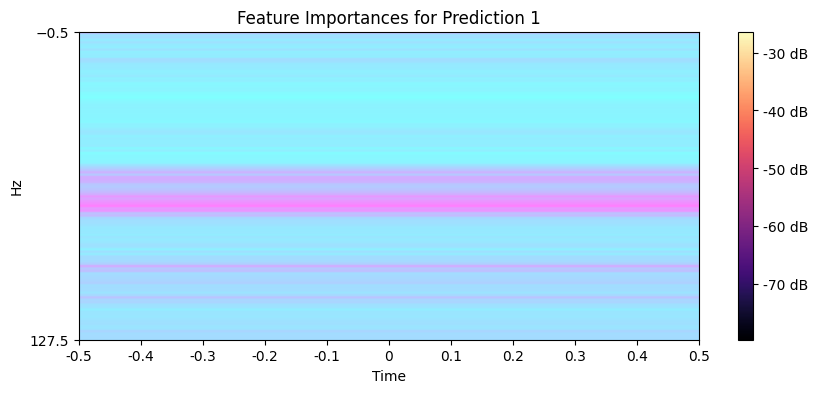

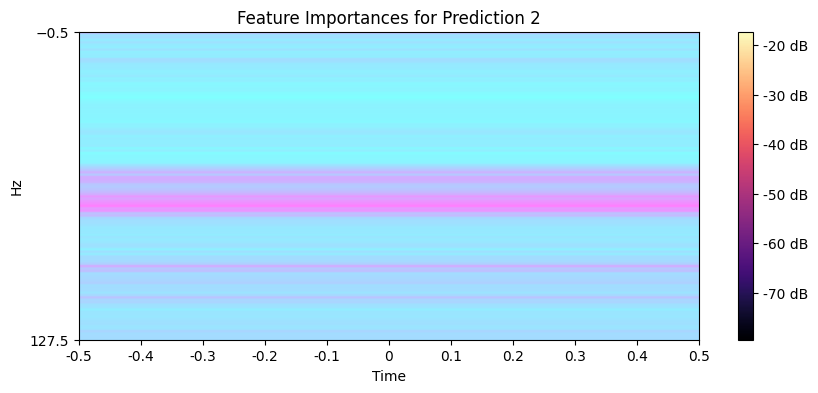

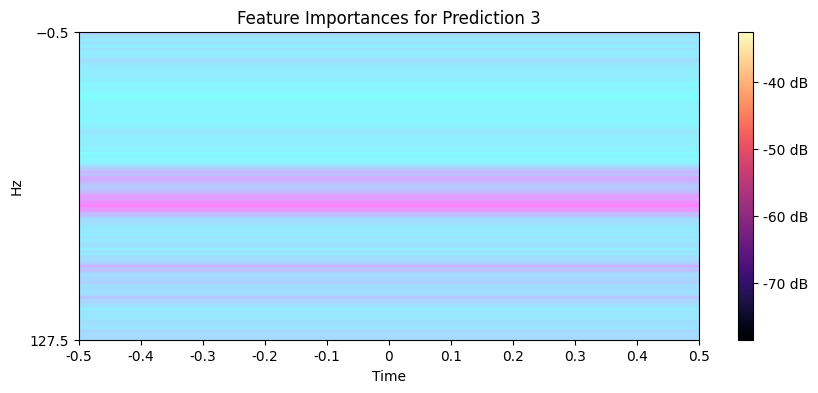

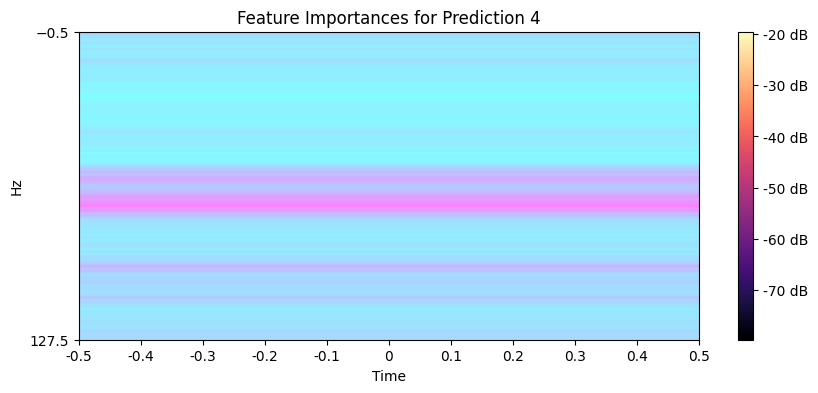

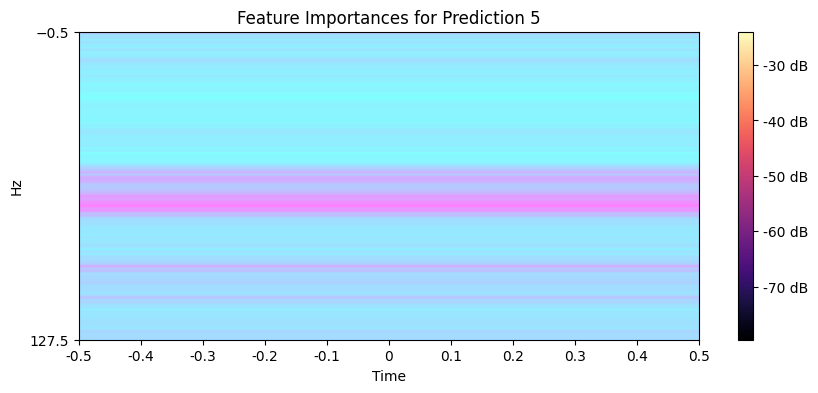

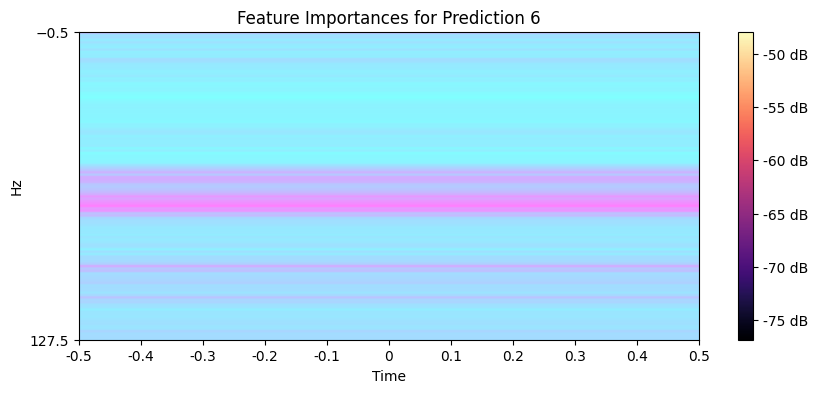

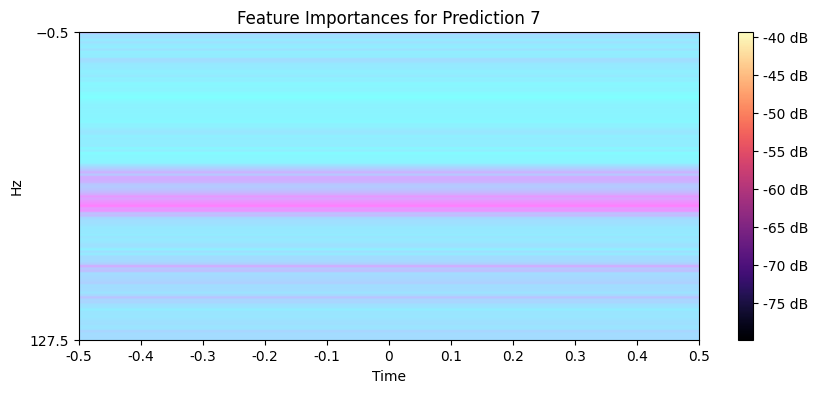

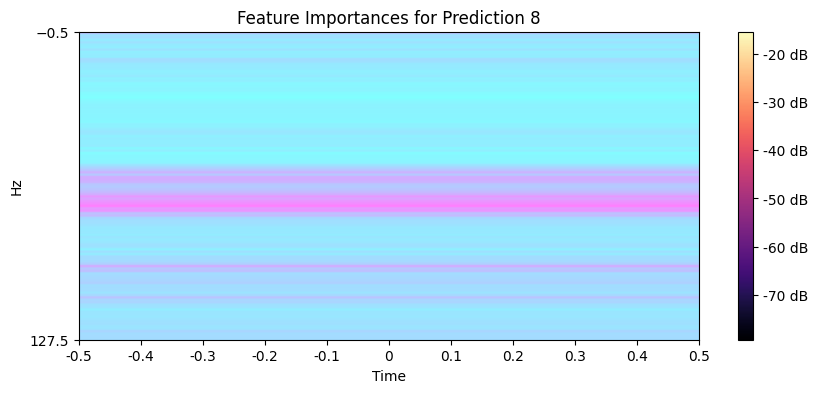

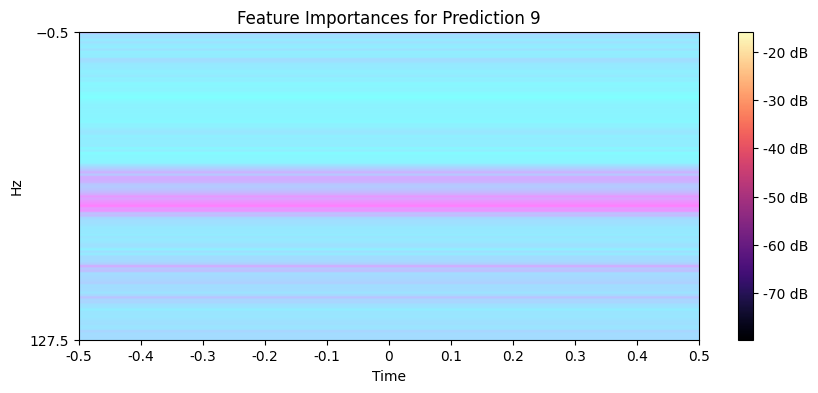

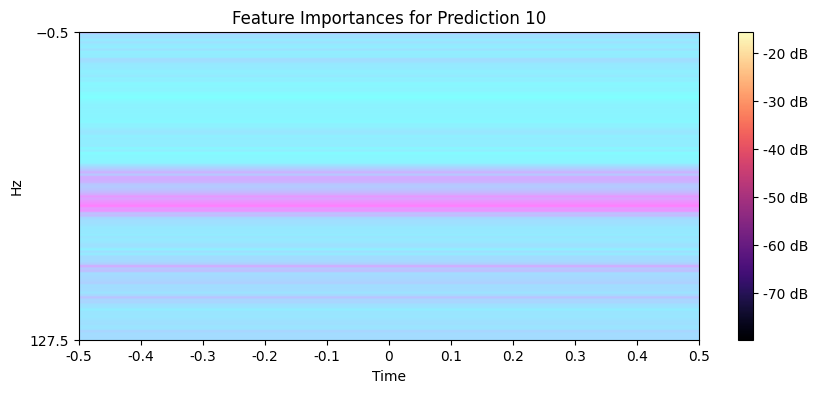

In [20]:
# Visualize Mel Spectrograms with overlaid feature importances
for i, mel_spec in enumerate(top_mel_specs):
    mel_spec_db = mel_spec.reshape(mel_shape)  # Reshape flattened Mel Spectrogram back to its original shape

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+0.0f dB')
    plt.title(f'Feature Importances for Prediction {i+1}')
    plt.imshow(importances_reshaped, cmap='cool', alpha=0.5, aspect='auto')
    plt.show()


In [24]:
import zipfile
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import shap


metadata_path = '/content/drive/MyDrive/Bird sound classification data/bird_songs_metadata.csv'
zip_path = '/content/drive/MyDrive/Bird sound classification data/archive (1).zip'
metadata = pd.read_csv(metadata_path)


species_of_interest = ['bewickii', 'polyglottos', 'migratorius', 'melodia', 'cardinalis']
metadata = metadata[metadata['species'].isin(species_of_interest)]

feature_list = []
labels = []
file_paths = []


with zipfile.ZipFile(zip_path, 'r') as z:
    for index, row in metadata.iterrows():
        file_path = os.path.join('wavfiles', row['filename'])
        if file_path in z.namelist():
            S_DB, sr, y = extract_features(file_path, z)
            feature_list.append(np.mean(S_DB, axis=1))
            labels.append(row['species'])
            file_paths.append(file_path)

features = np.array(feature_list)
labels = np.array(labels)
file_paths = np.array(file_paths)

X_train, X_test, y_train, y_test, file_paths_train, file_paths_test = train_test_split(features, labels, file_paths, test_size=0.2, random_state=42)


In [25]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)


probabilities = rf.predict_proba(X_test_scaled)
max_confidence_indices = np.argsort(np.max(probabilities, axis=1))[-10:]


Top 10 confidence audio files:
['wavfiles/564324-4.wav' 'wavfiles/563612-5.wav' 'wavfiles/321902-2.wav'
 'wavfiles/469588-9.wav' 'wavfiles/423449-4.wav' 'wavfiles/408014-9.wav'
 'wavfiles/563612-8.wav' 'wavfiles/563612-12.wav' 'wavfiles/11846-8.wav'
 'wavfiles/562449-3.wav']


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


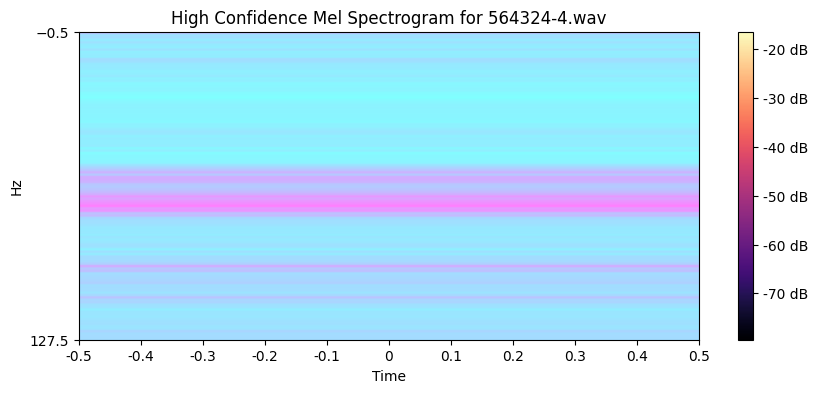

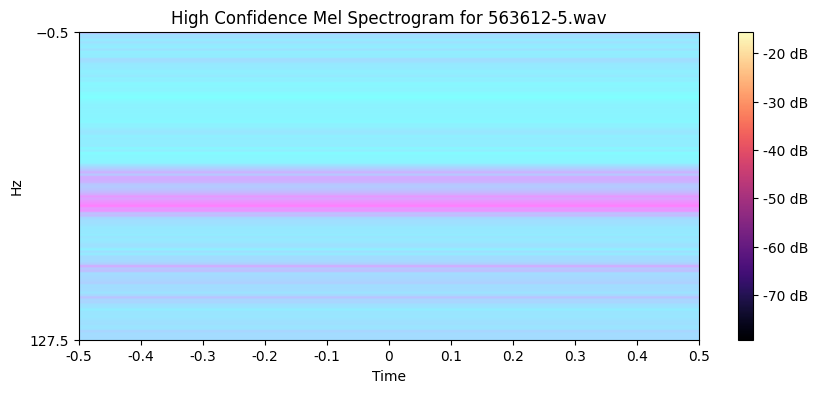

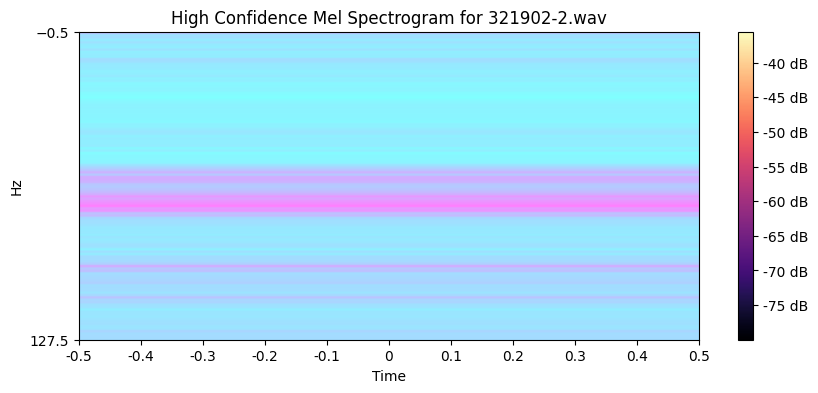

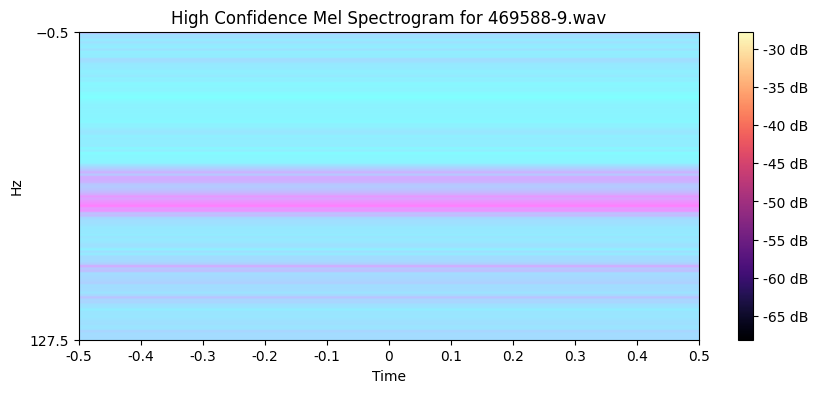

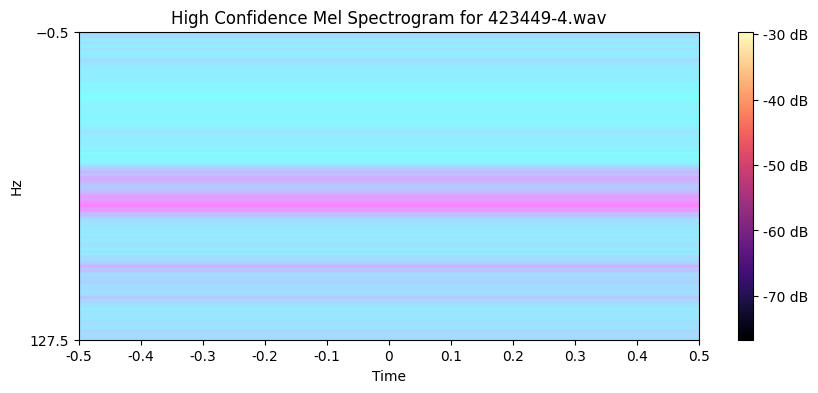

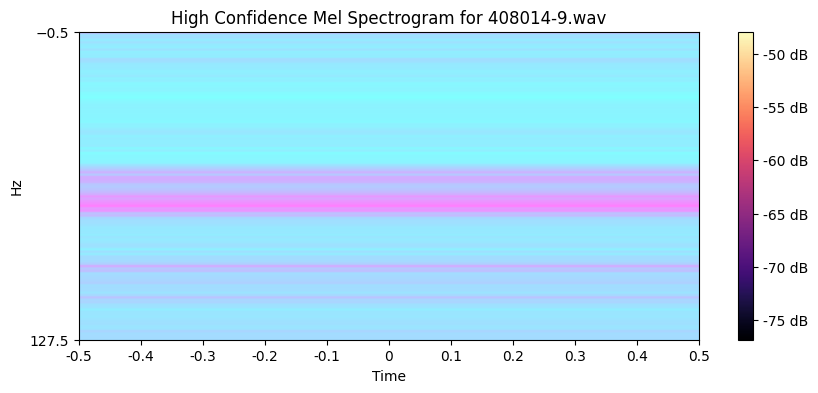

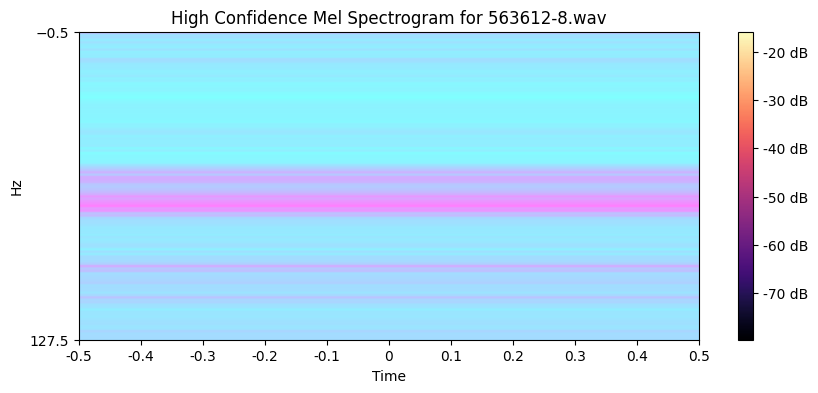

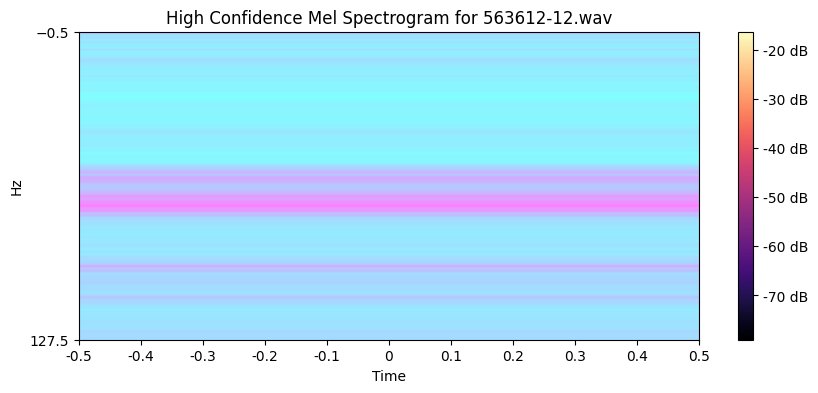

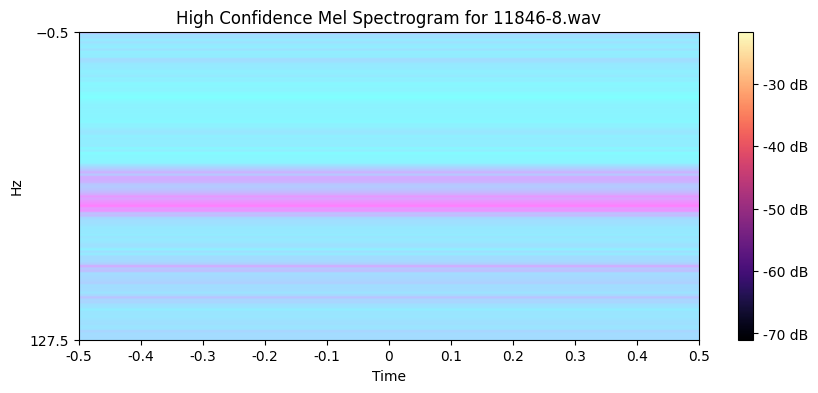

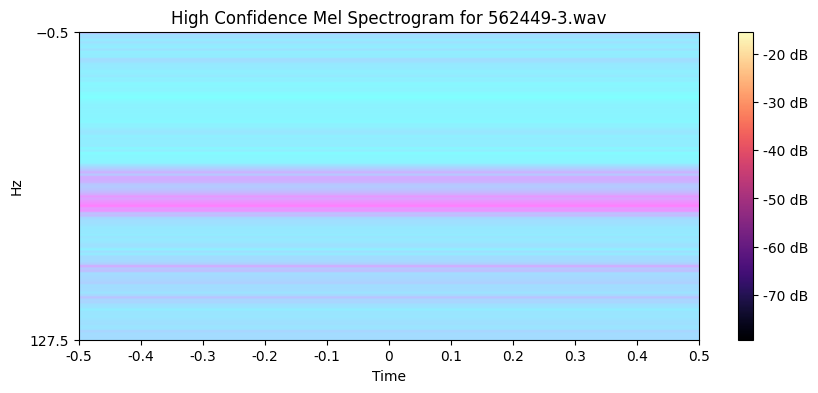

In [26]:

top_files = file_paths_test[max_confidence_indices]
print("Top 10 confidence audio files:")
print(top_files)


for i, (mel_spec, file_path) in enumerate(zip(X_test[max_confidence_indices], top_files)):
    mel_spec_db = mel_spec.reshape(128, -1)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+0.0f dB')
    plt.title(f'High Confidence Mel Spectrogram for {os.path.basename(file_path)}')
    plt.imshow(importances_reshaped, cmap='cool', alpha=0.5, aspect='auto')
    plt.show()

Top 10 confidence audio files:
['wavfiles/564324-4.wav' 'wavfiles/563612-5.wav' 'wavfiles/321902-2.wav'
 'wavfiles/469588-9.wav' 'wavfiles/423449-4.wav' 'wavfiles/408014-9.wav'
 'wavfiles/563612-8.wav' 'wavfiles/563612-12.wav' 'wavfiles/11846-8.wav'
 'wavfiles/562449-3.wav']


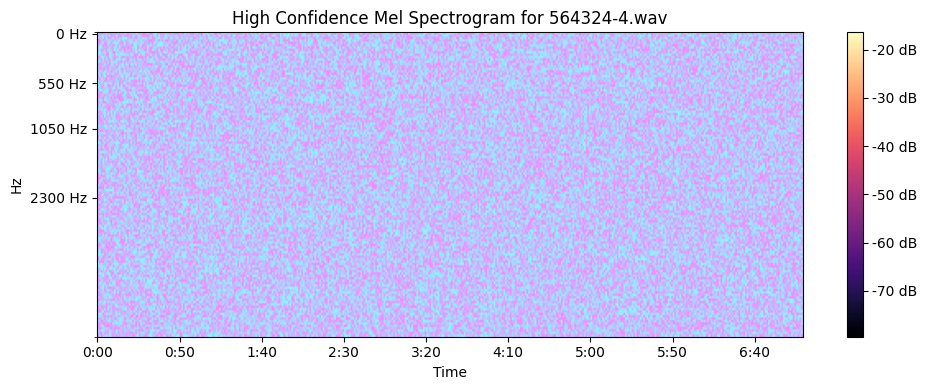

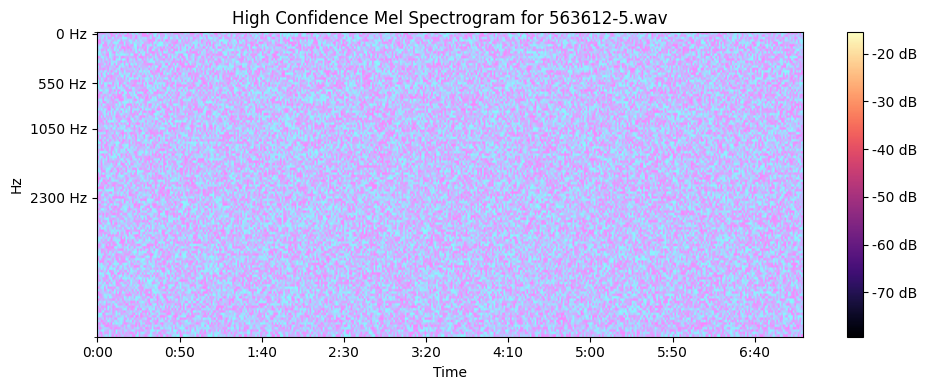

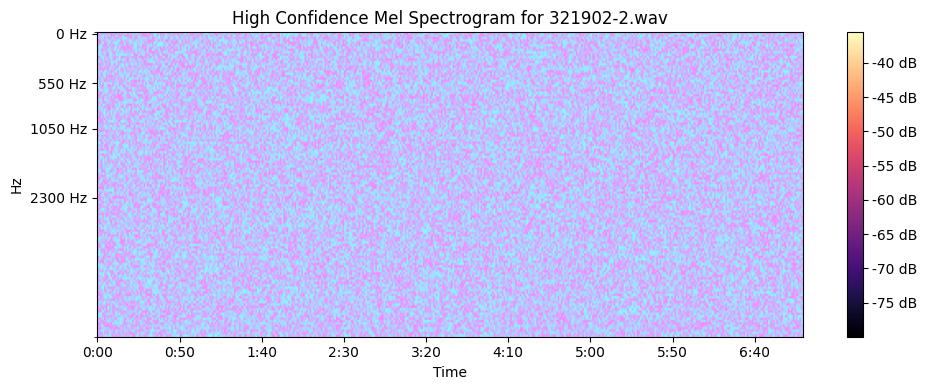

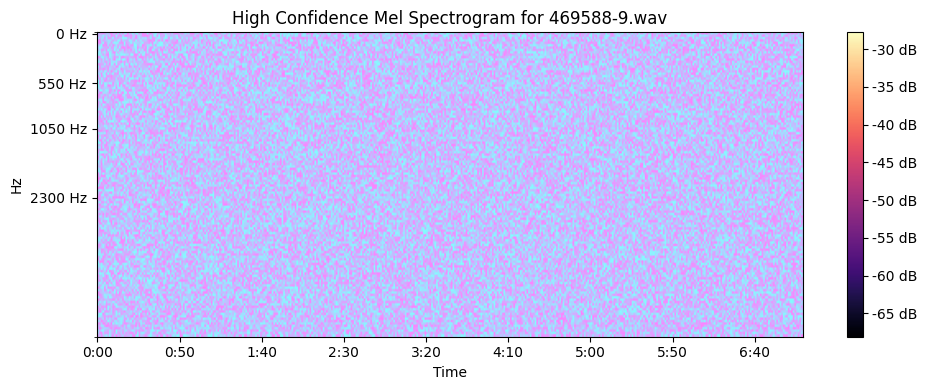

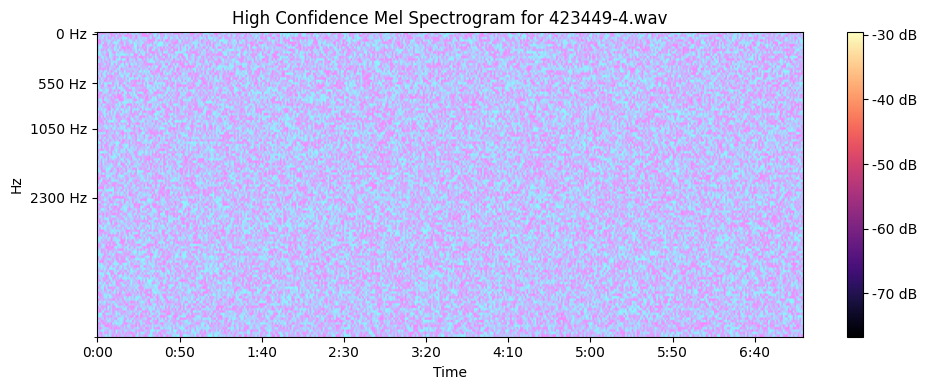

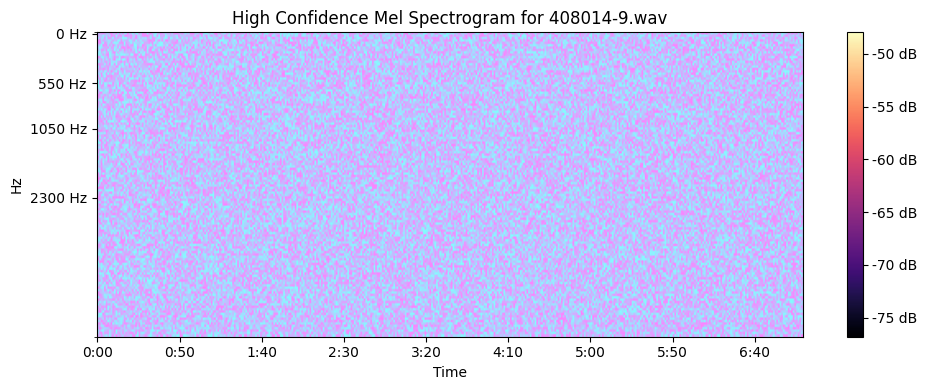

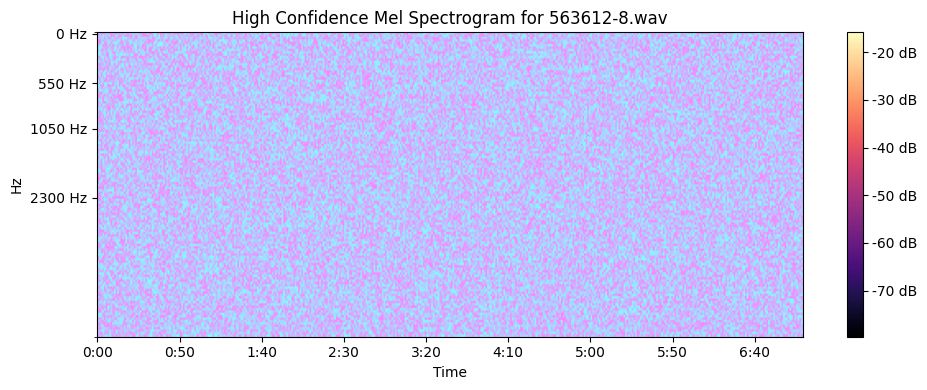

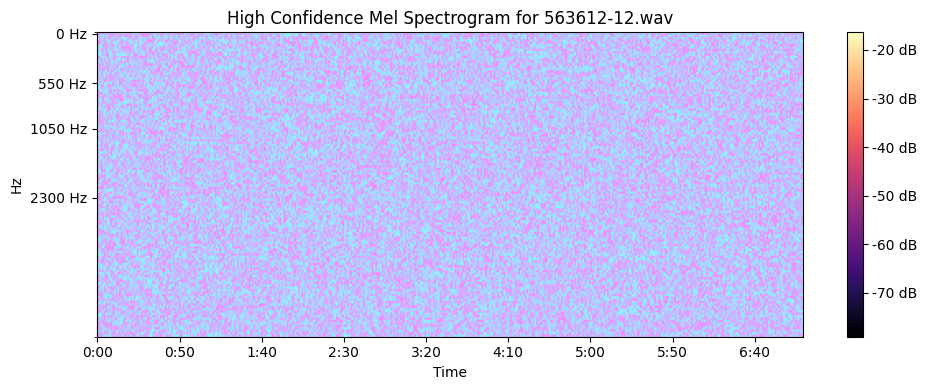

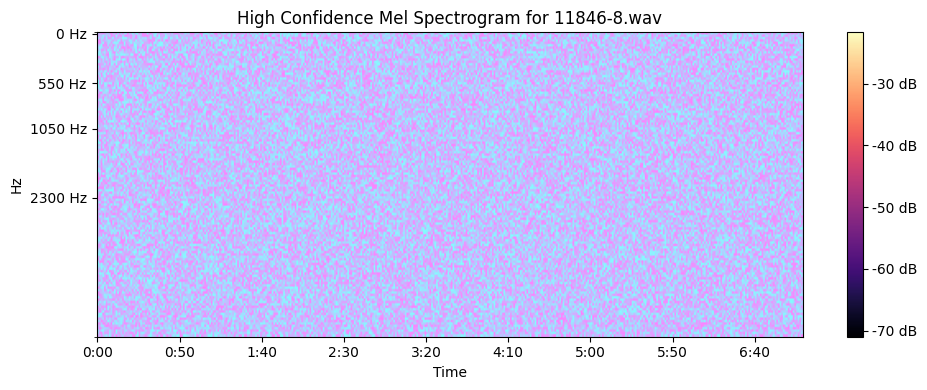

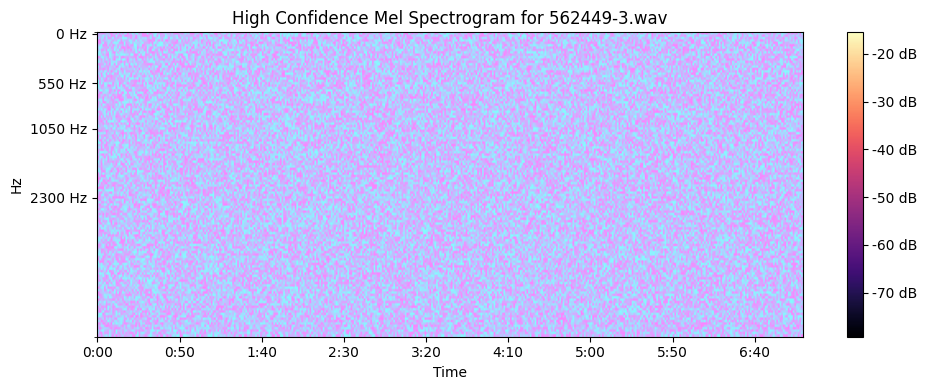

In [32]:
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt

# Assuming `sr` is the sample rate used for the Mel spectrograms
n_mels = 128  # Number of Mel bins
mel_frequencies = librosa.mel_frequencies(n_mels=n_mels, fmin=0, fmax=sr/2)  # Calculate Mel frequencies

# Find indices where the frequency is a multiple of 50 Hz
freq_indices = [i for i, f in enumerate(mel_frequencies) if int(f) % 50 == 0]
freq_labels = [f"{int(f)} Hz" for f in mel_frequencies if int(f) % 50 == 0]  # Labels for the y-axis

# Output file names with high confidence
top_files = file_paths_test[max_confidence_indices]
print("Top 10 confidence audio files:")
print(top_files)

# Visualize Mel Spectrograms with overlaid feature importances
for i, (mel_spec, file_path) in enumerate(zip(X_test[max_confidence_indices], top_files)):
    mel_spec_db = mel_spec.reshape(128, -1)  # Reshape mel_spec to its original Mel spectrogram shape
    plt.figure(figsize=(10, 4))
    ax = plt.gca()  # Get the current axis
    img = librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=ax)
    plt.colorbar(img, format='%+0.0f dB')
    plt.title(f'High Confidence Mel Spectrogram for {os.path.basename(file_path)}')

    # Set custom y-ticks
    ax.set_yticks(freq_indices)
    ax.set_yticklabels(freq_labels)

    # Overlay feature importances
    plt.imshow(importances_reshaped, cmap='cool', alpha=0.5, aspect='auto')
    plt.tight_layout()  # Ensure everything fits without overlapping
    plt.show()
